>  Scienze
BEFORE OVERSAMPLING:
Count of labels with 0: 805
Count of labels with 1: 161
AFTER OVERSAMPLING:
Count of labels with 0: 805
Count of labels with 1: 805

Scienze >  SVM + SMOTE + GRID + CROSSVALIDATION (PIPELINE)
Sensitivity: 0.13
Precision: 0.30
Accuracy: 0.80
Roc_auc: 0.63
Speciticity: 0.94


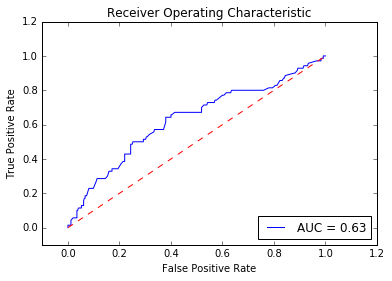

In [1]:

# coding: utf-8

# In[6]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix

def roc_plot(fp,tp,roc_auc):   
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def metrics():
    global currentModel
    from sklearn.metrics import auc, roc_curve
    import matplotlib.pyplot as plt

    cfm = confusion_matrix(y_test.values, predictions)
    tn, fp, fn, tp = cfm.ravel()
    specificity = tn/(tn + fp)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions_scores)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    scoring = { 'Accuracy' : (tn + tp)/(tn + tp + fn + fp),
                'Sensitivity' : tp/(tp + fn),
                'Speciticity' : specificity,
                'Precision' : tp/(fp + tp),
                'ROC_AUC' : roc_auc
              }
    print(scuola[idScuola],"> ", currentModel)
    for i in scoring.keys():
        print('%s: %0.2f' % (i.capitalize(), scoring[i]))
    roc_plot(false_positive_rate,true_positive_rate,roc_auc)    

# ignore warnigs due to deprecated method when using v. 3.* intead of 2.*
warnings.simplefilter('ignore')


# In[10]:



dataset_path = "/home/ale/Scrivania/dropout_IA/files/data.xlsx"
df = pd.read_excel(dataset_path)
df = df.drop(columns=['ID_studente', 'Situazione_OFA','Voto_scuola_sup','Corso_di_studio_IDAggr'])
scuola = {
    1: "Agraria e Medicina veterinaria",
    2: "Economia, Management e Statistica",
    3: "Farmacia, Biotecnologie e Scienze motorie",
    4: "Giurisprudenza",
    5: "Ingegneria e Architettura",
    6: "Lettere e Beni culturali",
    7: "Lingue e Letterature, Traduzione e Interpretazione",
    8: "Medicina e Chirurgia",
    9: "Psicologia e Scienze della Formazione",
    10: "Scienze",
    11: "Scienze politiche"
}
studenti = {}
grouped = df.groupby('Scuola')
dropped = []
cont = []
rate = []
total = []
for name,group in grouped:
    
    studenti[name] = grouped.get_group(name)
    d = len(studenti[name].loc[studenti[name]['Abbandoni'] == 1])
    c = len(studenti[name].loc[studenti[name]['Abbandoni'] == 0])
    dropped.append(d)
    cont.append(c)
    rate.append(round(d/c,2))
    total.append(d+c)
table = pd.DataFrame({'ID':list(scuola.keys()),'Dropped': dropped, 'Cont':cont,'Total':total,'Rate D/C': rate}, index=list(scuola.values()))
table


# In[3]:


idScuola = 10


# ## SPLIT DATASET AND SMOTE

# In[4]:


from sklearn.model_selection import train_test_split
X = studenti[idScuola].iloc[:,:-1]
y = studenti[idScuola].iloc[:,-1]

#Being imbalanced classification, we cannot ensure the predictions will be correct for the minority class
#So we will perform a SMOTE to balance out the two classes. Lets split the dataset into train and test before that
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from imblearn.over_sampling import SMOTE

#Smote will only be applied on the training dataset
print('> ',scuola[idScuola])

print('BEFORE OVERSAMPLING:')
print('Count of labels with 0: {}'.format(sum(y_train==0)))
print('Count of labels with 1: {}'.format(sum(y_train==1)))

sm = SMOTE(random_state=3, k_neighbors=5, kind="svm")
#sm = SMOTE(random_state=2, k_neighbors=5, kind="borderline2")
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('AFTER OVERSAMPLING:')
print('Count of labels with 0: {}'.format(sum(y_train_res==0)))
print('Count of labels with 1: {}\n'.format(sum(y_train_res==1)))


# In[7]:


from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
currentModel = "SVM + SMOTE + GRID + CROSSVALIDATION (PIPELINE)"

pipe = Pipeline([
    ('oversample', sm),
    ('clf', SVC(probability=True, random_state=1))
    ])

param_grid = {'clf__C': [0.01,0.1,1,10,1000]}

gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=10, verbose=0, n_jobs=-1)

gs.fit(X_train, y_train)
clf = gs.best_estimator_
pipe2 = Pipeline([
    ('oversample', sm),
    ('clf', clf)
    ])

pipe2.fit(X_train, y_train)
predictions = pipe2.predict(X_test)
predictions_scores = pipe2.predict_proba(X_test)[:,1]

#compute_metrics(y_test, predictions, predictions_scores)
#compute_prediction_classes_count(predictions)
metrics()


# In[ ]:


from sklearn.ensemble import RandomForestClassifier    
currentModel = "RandomForest"
clf = RandomForestClassifier(random_state=123, class_weight='balanced')


# In[ ]:


from xgboost import XGBClassifier
currentModel = "XGBOOST"
clf = XGBClassifier()

